# Laboratorio 7: Redes LSTM

Construiremos dos ejemplos de redes neuronales recurrentes utilizando LSTM.

## 1. Descargar las base de datos de dos series de tiempo

In [1]:
#https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2020-08-27 01:20:58--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519 [text/plain]
Saving to: ‘shampoo.csv’

shampoo.csv         100%[===================>]     519  --.-KB/s    in 0s      

2020-08-27 01:20:58 (12.3 MB/s) - ‘shampoo.csv’ saved [519/519]

--2020-08-27 01:20:58--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.

## 2. Cargar librerías

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

## 3. Cargando y revisando los datos de pasajeros de una aerolínea

Leer los datos utilizando Pandas.

In [12]:
training_set = pd.read_csv('/content/airline-passengers.csv')

training_set.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Graficamos los datos.

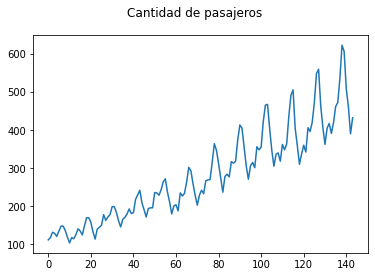

In [13]:
training_set = training_set.iloc[:, 1:2].values

plt.plot(training_set)
plt.suptitle('Cantidad de pasajeros')
plt.show()

## 4. Creación de ventana deslizante

Creamos una ventana deslizante, dada una secuencia de tamaño n se desea predecir el siguiente punto.

In [14]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)
#escalamos los datos
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

## 5. Seleccionamos datos de entrenamiento y validación

Creamos dos particiones una de entrenamiento y otra de validación. Donde esta última, son los datos después de cierta fecha.

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Conjunto de entrenamiento
train_size = int(len(y) * 0.67)
# Conjunto validacion
val_size = len(y) - train_size

x_train = torch.tensor(x[0:train_size],device=device)
y_train = torch.tensor(y[0:train_size],device=device)
x_val = torch.tensor(x[val_size:],device=device)
y_val = torch.tensor(y[val_size:],device=device)

x = torch.tensor(x,device=device)
y = torch.tensor(y,device=device)

Modelo

In [16]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):    
      ula, (h_n, _) = self.lstm(x)
      h_n = h_n.view(-1, self.hidden_size)
      out = self.fc(h_n)

      return out

In [17]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

#por defecto se crea una lstm con precision de 16bit, en pytorch 1.6.0 hay un bug que no permite el uso de 16bit con lstm
#pasamos la red a doble precision
lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device).double()


criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Entrenamiento
for epoch in range(num_epochs):
    outputs = lstm(x_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.06237
Epoch: 100, loss: 0.01206
Epoch: 200, loss: 0.00275
Epoch: 300, loss: 0.00203
Epoch: 400, loss: 0.00170
Epoch: 500, loss: 0.00166
Epoch: 600, loss: 0.00164
Epoch: 700, loss: 0.00162
Epoch: 800, loss: 0.00161
Epoch: 900, loss: 0.00159
Epoch: 1000, loss: 0.00158
Epoch: 1100, loss: 0.00157
Epoch: 1200, loss: 0.00157
Epoch: 1300, loss: 0.00156
Epoch: 1400, loss: 0.00156
Epoch: 1500, loss: 0.00155
Epoch: 1600, loss: 0.00155
Epoch: 1700, loss: 0.00155
Epoch: 1800, loss: 0.00154
Epoch: 1900, loss: 0.00154


Vemos el resultado sobre el set de datos

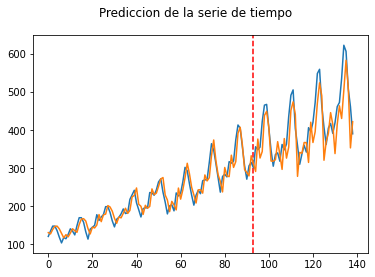

In [18]:
lstm.eval()
train_predict = lstm(x)

data_predict = train_predict.cpu().data.numpy()
dataY_plot = y.cpu().data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
#Dibujamos una linea roja que nos dira cuando comienza el set de validacion
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Prediccion de la serie de tiempo')
plt.show()

# Laboratorio: Base de datos Shampoo

In [ ]:
training_set = pd.read_csv('shampoo.csv')
training_set.head()

In [ ]:
training_set = training_set.iloc[:,1:2].values
plt.plot(training_set )
plt.suptitle('Ventas de shampoo')
plt.show()

In [ ]:
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)
seq_length = 4
x, y = sliding_windows(training_data, seq_length)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_size = int(len(y) * 0.67)
val_size = len(y) - train_size

x_train = torch.tensor(x[0:train_size],device=device)
y_train = torch.tensor(y[0:train_size],device=device)
x_val = torch.tensor(x[val_size:],device=device)
y_val = torch.tensor(y[val_size:],device=device)

x = torch.tensor(x,device=device)
y = torch.tensor(y,device=device)


In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

#por defecto se crea una lstm con precision de 16bit, en pytorch 1.6.0 hay un bug que no permite el uso de 16bit con lstm
#pasamos la red a doble precision
lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device).double()

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(x_train)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, y_train)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [ ]:
lstm.eval()
train_predict = lstm(x)

data_predict = train_predict.cpu().data.numpy()
dataY_plot = y.cpu().data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()